Title : Predict Dog Breed

Introduction: This project is to train the existing image classification model "ResNet50" to predict the dog breed. We will download the dog images from S3 bucket (from udacity S3 bucket) for training (transfer learining) the model. also, we will use SageMaker profiling, debugger & hyperparameter tuning. once transfer learning is completed, we will deploy the trained model and use the deployed model to do predictions on sample dog images.  


In [8]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [35]:
!pip install torchvision

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached torchvision-0.14.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)
  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset

The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

following stats are from original data set
train directory has 6680 dog images
test directory has 836 dog images
vald directory has 835 dog images

for taining data class distribution, please refer count histogram below.

As model training is taking lot of time, i have reduced the data to 10 dog breeds.
following stats are from reduced data set
train directory has 578 dog images
test directory has 73 dog images
vald directory has 71 dog images

TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-04 09:17:38--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.112
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  48.3MB/s    in 25s     

2023-02-04 09:18:11 (43.8 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [55]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/dogbreed1"
role = sagemaker.get_execution_role()
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

In [56]:
print(inputs)

s3://sagemaker-us-east-1-641973517703/sagemaker/dogbreed1


In [57]:
from sklearn.datasets import load_files
train_data = load_files("dogImages/train")


In [58]:
import numpy as np
print("Number of dog samplesin train data set")
len(train_data['target'])



Number of dog samplesin train data set


578

In [59]:
print("Number of dog breeds in train data set")
len(set(train_data['target']))


Number of dog breeds in train data set


10

In [60]:
test_data = load_files("dogImages/test")
vald_data = load_files("dogImages/valid")

In [61]:
print("Number of dog samples in test data set")
len(test_data['target'])

Number of dog samples in test data set


73

In [62]:
print("Number of dog samples in vald data set")
len(vald_data['target'])

Number of dog samples in vald data set


71

In [36]:
values, counts = np.unique(train_data['target'], return_counts=True)

In [37]:
import pandas as pd
train_labels_df = pd.DataFrame(data ={'label':values,'count':counts})
print("number of images per lable under train directory")
train_labels_df.describe()

number of images per lable under train directory


,label,count
count,133.00000,133.000000
mean,66.00000,50.225564
std,38.53786,11.863885
min,0.00000,26.000000
25%,33.00000,42.000000
50%,66.00000,50.000000
75%,99.00000,61.000000
max,132.00000,77.000000


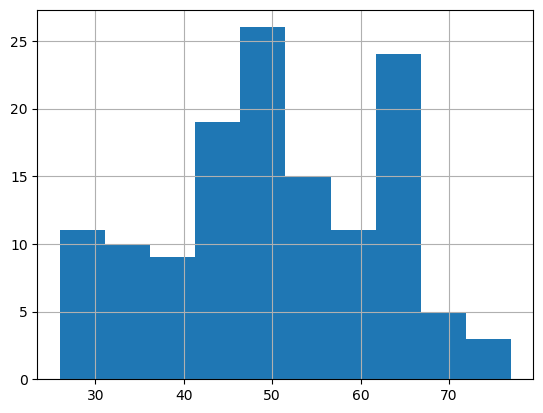

In [38]:
import matplotlib.pyplot as plt
train_labels_df['count'].hist()
plt.show()

In [63]:
values, counts = np.unique(train_data['target'], return_counts=True)
import pandas as pd
train_labels_df = pd.DataFrame(data ={'label':values,'count':counts})
print("number of images per lable under train directory")
train_labels_df.describe()

number of images per lable under train directory


,label,count
count,10.00000,10.00000
mean,5.50000,57.80000
std,3.02765,11.83967
min,1.00000,34.00000
25%,3.25000,50.50000
50%,5.50000,60.50000
75%,7.75000,64.00000
max,10.00000,77.00000


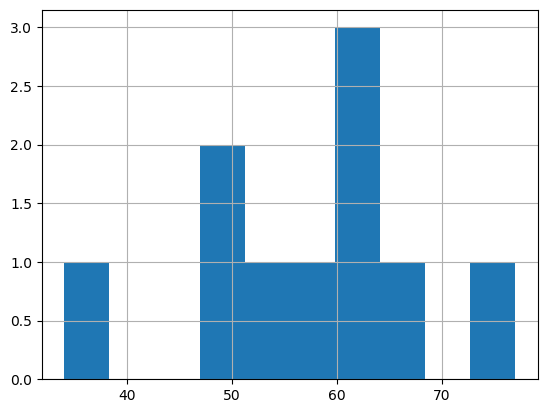

In [64]:
import matplotlib.pyplot as plt
train_labels_df['count'].hist()
plt.show()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [68]:
#TODO: Declare your HP ranges, metrics etc.
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([64, 128, 256]),
    "epochs":CategoricalParameter([2, 4, 6]),
    "test-batch-size":CategoricalParameter([15, 30, 73])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [69]:
#TODO: Create estimators for your HPs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [71]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [76]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()  #TODO

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
print(best_hyperparameters)


2023-02-04 17:11:31 Starting - Found matching resource for reuse
2023-02-04 17:11:31 Downloading - Downloading input data
2023-02-04 17:11:31 Training - Training image download completed. Training in progress.
2023-02-04 17:11:31 Uploading - Uploading generated training model
2023-02-04 17:11:31 Completed - Resource reused by training job: pytorch-training-230204-1636-006-1d2d54bf
{'_tuning_objective_metric': '"average test loss"', 'batch-size': '"128"', 'epochs': '"6"', 'lr': '0.006032054023873381', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2023-02-04-16-36-37-827"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-641973517703/pytorch-training-2023-02-04-16-36-37-827/source/sourcedir.tar.gz"', 'test-batch-size': '"30"'}


In [44]:
import sagemaker
import boto3
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/dogbreed1"
role = sagemaker.get_execution_role()

best_hypo =  {
    "epochs": 6, 
    "batch-size": 128, 
    "lr": 0.006032054023873381,
    'test-batch-size':30
}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [45]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, rule_configs
from sagemaker.debugger import ProfilerRule,CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile()
)

collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]


hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"},collection_configs=collection_configs
)

In [71]:
inputs = 's3://sagemaker-us-east-1-641973517703/sagemaker/dogbreed1'
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=best_hypo,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)

estimator.fit({"training": inputs},wait=True)

2023-02-05 03:51:36 Starting - Starting the training job...
2023-02-05 03:51:51 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-02-05 03:53:06 Downloading - Downloading input data...
2023-02-05 03:53:36 Training - Downloading the training image......
2023-02-05 03:54:36 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-05 03:54:21,430 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-05 03:54:21,433 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-05 03:54:21,442 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-

In [48]:
# TODO: Plot a debugging output.

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-05 03:12:38.372 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-641973517703/pytorch-training-2023-02-05-02-53-43-126/debug-output


In [49]:
trial.tensor_names()

[2023-02-05 03:12:45.573 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-05 03:12:46.594 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1'

In [50]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

30

In [51]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

20

In [52]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


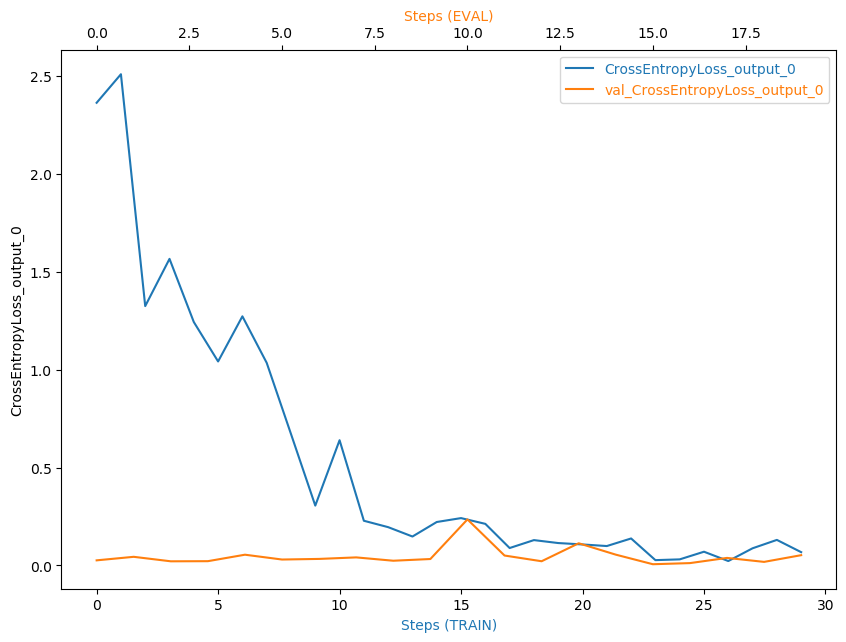

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "CrossEntropyLoss_output_0")



Observation 1 : VanishingGradient: Error
The gradient in a train became extremely small.vanishing gradient prevents the weight from changning its value. it might stop NN from further trianing. 
Batch normalization is a standard method to overcome this problem.



In [54]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

! aws s3 ls {rule_output_path} --recursive

2023-02-05 03:12:00     364217 pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-05 03:11:59     211275 pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-05 03:11:54        192 pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-05 03:11:54        200 pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-05 03:11:54       1695 pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-05 03:11:54        127 pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-05 03:11:54        199 pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-re

In [55]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-641973517703/pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-641973517703/pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-641973517703/pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-641973517703/pytorch-training-2023-02-05-02-53-43-126/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east

In [56]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [57]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [81]:
inputs = 's3://sagemaker-us-east-1-641973517703/sagemaker/dogbreed1'
# TODO: Create and fit an estimator

estimator1 = PyTorch(
    entry_point="script_for_Deploy_model.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=best_hypo,
    framework_version="1.8",
    py_version="py36"
)

estimator1.fit({"training": inputs},wait=True)

2023-02-05 04:52:28 Starting - Starting the training job...
2023-02-05 04:52:52 Starting - Preparing the instances for trainingProfilerReport-1675572748: InProgress
......
2023-02-05 04:53:53 Downloading - Downloading input data...
2023-02-05 04:54:20 Training - Downloading the training image......
2023-02-05 04:55:13 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-05 04:55:15,547 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-05 04:55:15,550 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-05 04:55:15,559 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-05 04:55:15,561 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-05 04:55:15,766 sagemaker-training-toolkit INFO     No GP

In [82]:
# TODO: Deploy your model to an endpoint

predictor=estimator1.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

------!

In [83]:
endpoint_name = predictor.endpoint_name
print("End Point Name")
print(endpoint_name)

End Point Name
pytorch-training-2023-02-05-05-10-06-881


In [84]:
from PIL import Image
from torchvision import transforms
import torch

test_img = Image.open("dogImages/test/006.American_eskimo_dog/American_eskimo_dog_00452.jpg")
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_tensor = transform(test_img)
test_batch = test_tensor.unsqueeze(0)

test_data = test_batch.numpy()

from sagemaker.predictor import Predictor
from sagemaker.serializers import NumpySerializer

predictor = Predictor(endpoint_name)
predictor.serializer = NumpySerializer()

In [85]:
# TODO: Run an prediction on the endpoint

#image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(test_data)

In [86]:
print(response)

b'[[-3.5900344848632812, -1.4078658819198608, -4.629725456237793, 4.118197917938232, 2.2168056964874268, 6.205235004425049, -1.8407270908355713, -5.7975287437438965, -1.1168252229690552, -0.7345839738845825]]'


In [87]:
import ast

prediction = ast.literal_eval(str(response)[3:-2])

prediction.index(max(prediction)) + 1

6

In [88]:
test_img = Image.open("dogImages/valid/004.Akita/Akita_00227.jpg")
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_tensor = transform(test_img)
test_batch = test_tensor.unsqueeze(0)

test_data = test_batch.numpy()
response = predictor.predict(test_data)

prediction = ast.literal_eval(str(response)[3:-2])

prediction.index(max(prediction)) + 1

4

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()